In [0]:
import cv2 
from matplotlib import pyplot as plt
import numpy as np 
import torch
import torch.nn as nn
import torchvision.datasets as dsets 
from skimage import transform
import torchvision.transforms as transforms
from torch.autograd import Variable
import pandas as pd
from torch.utils.data import Dataset, DataLoader
from keras.utils import *
import random
import math
import os
from torchvision import datasets, transforms
from torch import nn, optim
import seaborn
import torch
import torch.nn.functional as F
from pylab import *
# from nano.pytorch import helper
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
from collections import OrderedDict
import torch.optim as optim
# from torchvision.datasets.mnist import MNIST
import torchvision.transforms as transforms
from torch.utils.data import DataLoader

Using TensorFlow backend.


In [0]:
get_ipython().run_line_magic('matplotlib', 'inline')
get_ipython().run_line_magic('config', "InlineBackend.figure_format = 'retina'")
seaborn.set(style="whitegrid",
            rc={"axes.grid": False,
                "font.family": ["sans-serif"],
                "font.sans-serif": ["Latin Modern Sans", "Lato"],
                "figure.figsize": (8, 6)},
            font_scale=1)

In [0]:
epochs = 25;
batch_size = 128;
learning_rate = 0.001;

In [0]:
data_train = datasets.FashionMNIST('./data/F_MNIST',
                   download=True,
                   transform=transforms.Compose([
                       transforms.Resize((32, 32)),
                       transforms.ToTensor()]))
data_test = datasets.FashionMNIST('./data/F_MNIST',
                  train=False,
                  download=True,
                  transform=transforms.Compose([
                      transforms.Resize((32, 32)),
                      transforms.ToTensor()]))
data_train_loader = DataLoader(data_train, batch_size=256, shuffle=True, num_workers=8)
data_test_loader = DataLoader(data_test, batch_size=256, num_workers=8)

0it [00:00, ?it/s]

26427392it [00:02, 9946636.01it/s]                              


Extracting ./data/F_MNIST/FashionMNIST/raw/train-images-idx3-ubyte.gz to ./data/F_MNIST/FashionMNIST/raw


0it [00:00, ?it/s]

32768it [00:00, 71506.14it/s]                            
0it [00:00, ?it/s]

Extracting ./data/F_MNIST/FashionMNIST/raw/train-labels-idx1-ubyte.gz to ./data/F_MNIST/FashionMNIST/raw


4423680it [00:01, 3037548.70it/s]                            
0it [00:00, ?it/s]

Extracting ./data/F_MNIST/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to ./data/F_MNIST/FashionMNIST/raw


8192it [00:00, 22991.10it/s]            

Extracting ./data/F_MNIST/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/F_MNIST/FashionMNIST/raw
Processing...
Done!


In [0]:
labels_map = {0 : 'T-Shirt', 1 : 'Trouser', 2 : 'Pullover', 3 : 'Dress', 4 : 'Coat', 5 : 'Sandal', 6 : 'Shirt',
              7 : 'Sneaker', 8 : 'Bag', 9 : 'Ankle Boot'};

In [0]:
class LeNet5(nn.Module):
    """
    Input - 1x32x32
    C1 - 6@28x28 (5x5 kernel)--> tanh --> S2 - 6@14x14 (2x2 kernel, stride 2) Subsampling --> C3 - 16@10x10 (5x5 kernel, complicated shit)--> tanh--> S4 - 16@5x5 (2x2 kernel, stride 2) Subsampling 
    --> C5 - 120@1x1 (5x5 kernel) --> F6 - 84 --> tanh --> F7 - 10 (Output)
    """
    def __init__(self):
        super(LeNet5, self).__init__()

        self.convnet = nn.Sequential(OrderedDict([
            ('c1', nn.Conv2d(1, 6, kernel_size=(5, 5))),
            ('relu1', nn.ReLU()),
            ('s2', nn.MaxPool2d(kernel_size=(2, 2), stride=2)),
            ('c3', nn.Conv2d(6, 16, kernel_size=(5, 5))),
            ('relu3', nn.ReLU()),
            ('s4', nn.MaxPool2d(kernel_size=(2, 2), stride=2)),
            ('c5', nn.Conv2d(16, 120, kernel_size=(5, 5))),
            ('relu5', nn.ReLU())
        ]))

        self.fc = nn.Sequential(OrderedDict([
            ('f6', nn.Linear(120, 84)),
            ('relu6', nn.ReLU()),
            ('f7', nn.Linear(84, 10)),
            ('sig7', nn.LogSoftmax(dim=-1))
        ]))

    def forward(self, img):
        output = self.convnet(img)
        output = output.view(img.size(0), -1)
        output = self.fc(output)
        return output

In [0]:
cnn = LeNet5().to(device);
# cnn = CNN()
#loss function and optimizer
criterion = nn.CrossEntropyLoss();
optimizer = torch.optim.Adam(cnn.parameters(), lr=learning_rate);
losses = [];

In [0]:
train_losses, validation_losses,accuracy_list = [],[],[]
for e in range(epochs):
    train_loss = 0
    validation_loss = 0
    accuracy = 0
    for images, labels in data_train_loader:
        images, labels = images.to(device), labels.to(device) ## Move to Cuda
        optimizer.zero_grad()
        op = cnn(images)
        loss = criterion(op, labels)
        train_loss += loss.item()
        loss.backward()
        optimizer.step()
    else:
        with torch.no_grad():
            cnn.eval()
            for images,labels in data_train_loader:
                images, labels = images.to(device), labels.to(device) ## Move to Cuda
                log_ps = cnn(images)
                prob = torch.exp(log_ps)
                top_probs, top_classes = prob.topk(1, dim=1)
                equals = labels == top_classes.view(labels.shape)
                accuracy += equals.type(torch.FloatTensor).mean()
                
                # validation_loss += criterion(log_ps, labels)
        cnn.train()
    print("Epoch: {}/{}.. ".format(e+1, epochs),
              "Training Loss: {:.3f}.. ".format(train_loss/len(data_train_loader)),
              # "validation Loss: {:.3f}.. ".format(validation_loss/len(validate_loader)),
              "Traning Accuracy: {:.3f}".format(accuracy/len(data_train_loader)))
    train_losses.append(train_loss/len(data_train_loader))
    accuracy_list.append(accuracy/len(data_train_loader))
    #validation_losses.append(validation_loss/len(train_loader))

Epoch: 1/25..  Training Loss: 0.890..  Traning Accuracy: 0.777
Epoch: 2/25..  Training Loss: 0.546..  Traning Accuracy: 0.816
Epoch: 3/25..  Training Loss: 0.474..  Traning Accuracy: 0.842
Epoch: 4/25..  Training Loss: 0.426..  Traning Accuracy: 0.850
Epoch: 5/25..  Training Loss: 0.394..  Traning Accuracy: 0.860
Epoch: 6/25..  Training Loss: 0.375..  Traning Accuracy: 0.872
Epoch: 7/25..  Training Loss: 0.354..  Traning Accuracy: 0.878
Epoch: 8/25..  Training Loss: 0.338..  Traning Accuracy: 0.885
Epoch: 9/25..  Training Loss: 0.325..  Traning Accuracy: 0.890
Epoch: 10/25..  Training Loss: 0.317..  Traning Accuracy: 0.888
Epoch: 11/25..  Training Loss: 0.307..  Traning Accuracy: 0.897
Epoch: 12/25..  Training Loss: 0.298..  Traning Accuracy: 0.890
Epoch: 13/25..  Training Loss: 0.292..  Traning Accuracy: 0.895
Epoch: 14/25..  Training Loss: 0.281..  Traning Accuracy: 0.897
Epoch: 15/25..  Training Loss: 0.275..  Traning Accuracy: 0.907
Epoch: 16/25..  Training Loss: 0.265..  Traning A

findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.


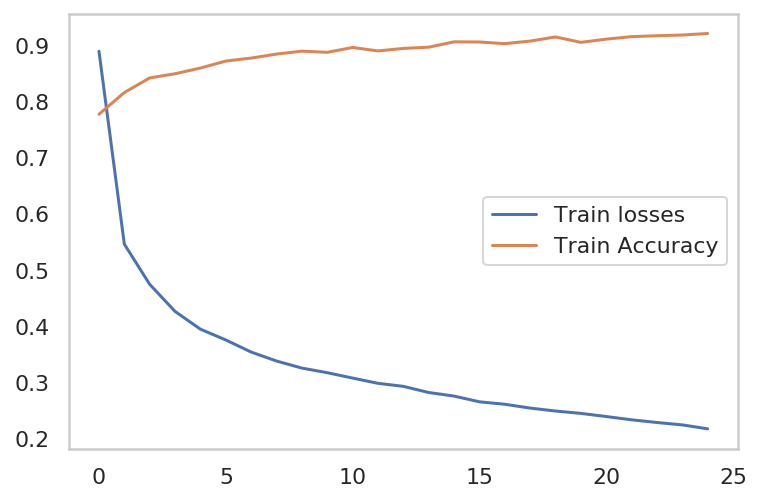

In [0]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.plot(train_losses,label = "Train losses")
plt.plot(accuracy_list, label = "Train Accuracy")
plt.legend()

In [0]:
def imshow(image, ax=None, title=None, normalize=True):
    """Imshow for Tensor."""
    if ax is None:
        fig, ax = plt.subplots()
    image = image.cpu().detach().numpy().transpose((1, 2, 0))

    if normalize:
        mean = np.array([0.5, 0.5, 0.5])
        std = np.array([0.5, 0.5, 0.5])
        image = std * image + mean
        image = np.clip(image, 0, 1)

    ax.imshow(image)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.tick_params(axis='both', length=0)
    ax.set_xticklabels('')
    ax.set_yticklabels('')


In [0]:
def view_classify(img, ps, version="MNIST", title = 0):
    ''' Function for viewing an image and it's predicted classes.
    '''
    title_order = ['T-shirt/top',
                            'Trouser',
                            'Pullover',
                            'Dress',
                            'Coat',
                            'Sandal',
                            'Shirt',
                            'Sneaker',
                            'Bag',
                            'Ankle Boot']
    # ps = ps.data.cpu()
    # img = img.cpu()
    ps = ps.data.cpu().detach().numpy().squeeze()

    fig, (ax1, ax2) = plt.subplots(figsize=(6,9), ncols=2)
    ax1.imshow(img.resize_(1, 32, 32).cpu().detach().numpy().squeeze())
    ax1.axis('off')
    ax2.barh(np.arange(10), ps)
    ax2.set_aspect(0.1)
    ax2.set_yticks(np.arange(10))
    if version == "MNIST":
        ax2.set_yticklabels(np.arange(10))
    elif version == "Fashion":
        ax2.set_yticklabels(title_order, size='small');
    ax2.set_title('Class Probability')
    ax2.set_xlim(0, 1.0)
    plt.tight_layout()
    plt.title("True: " + title_order[title])

In [0]:
def display_test(k):
    cnn.eval()
    count = 0;
    for images, labels in data_test_loader:
      if(count <= k):
        images, labels = images.to(device), labels.to(device) ## Move to Cuda
        for i in range(0,len(images)):
          # print()/
          if(count>=k):
            break;
          with torch.no_grad():
              output = cnn.forward(images[i].unsqueeze(0))
              count=count+1;
    
          ps = torch.exp(output)
    # sys.exit(1)
          view_classify(images[i].view(1,32,32), ps, version='Fashion', title=labels[i])

findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.


Graphical prediction of 20 images from testing data set


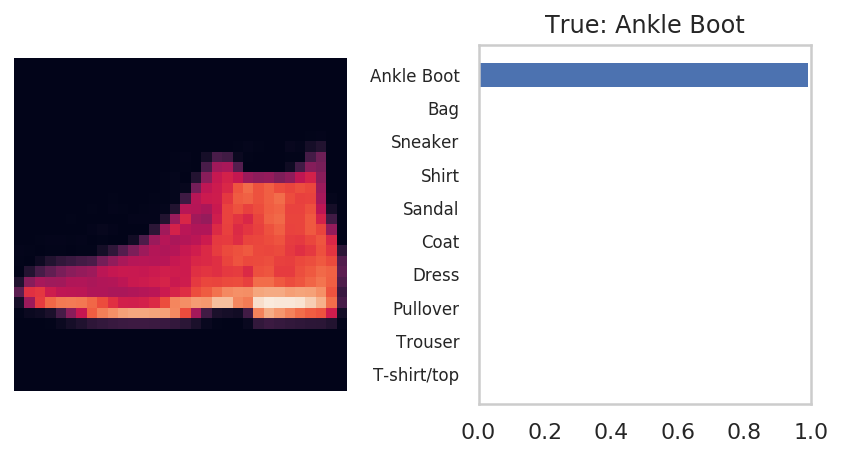

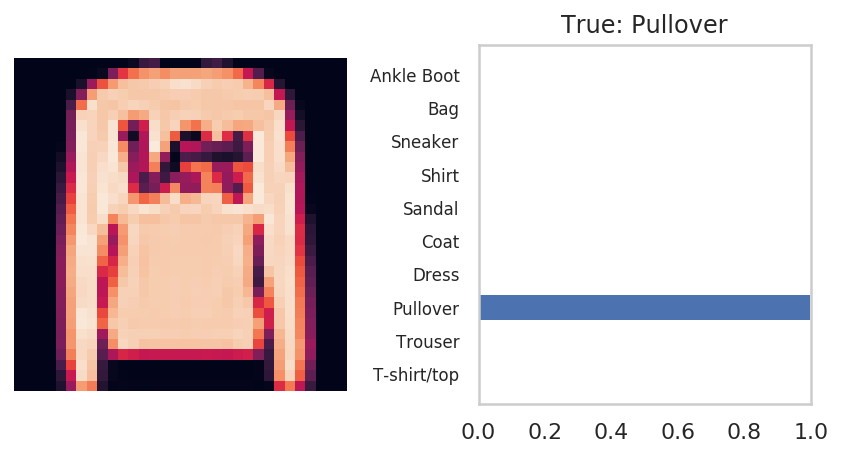

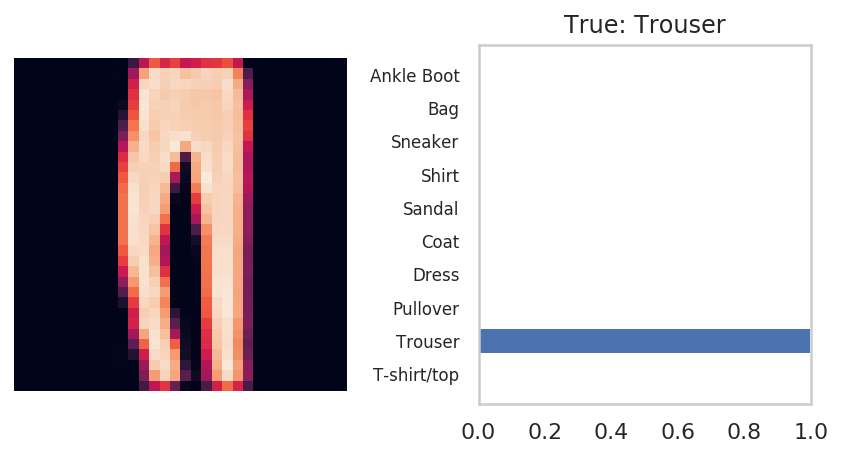

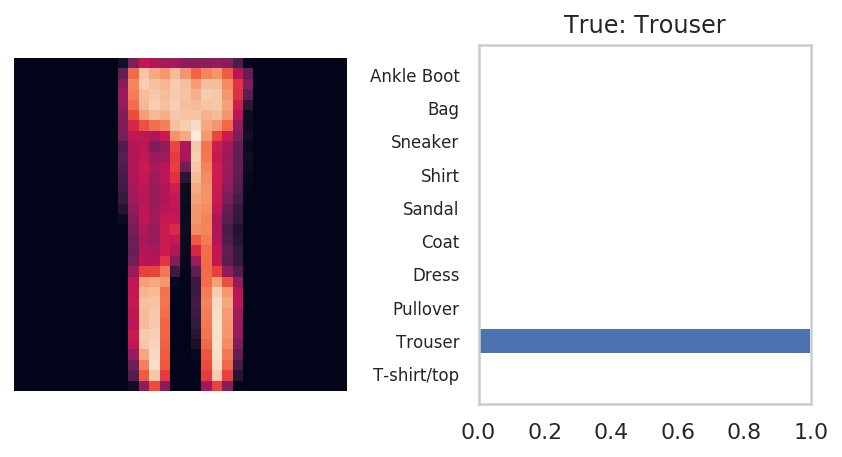

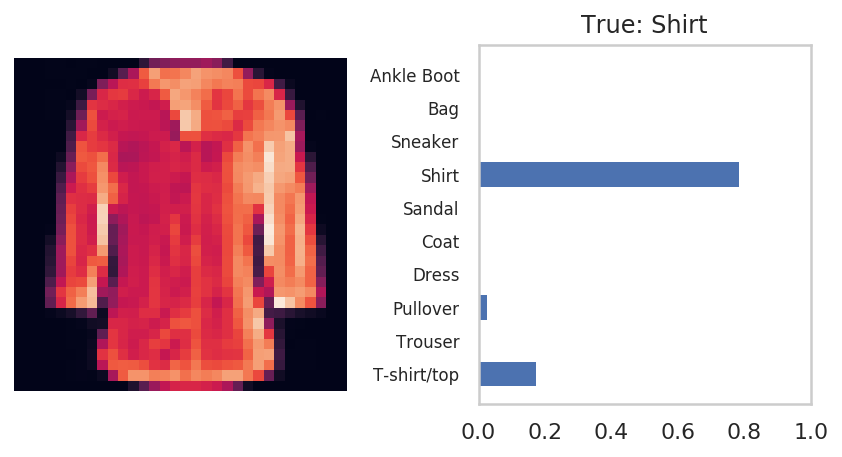

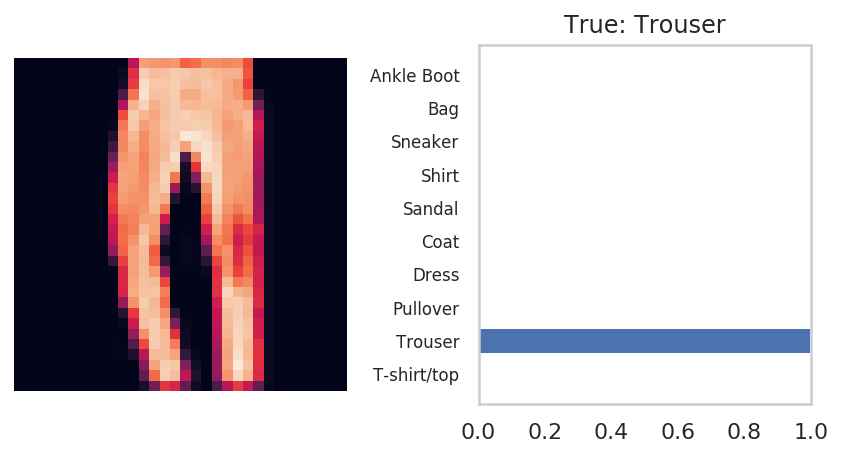

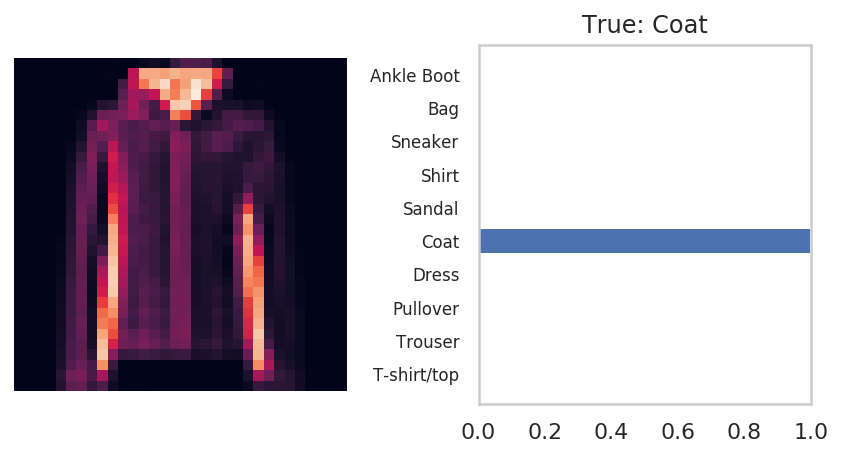

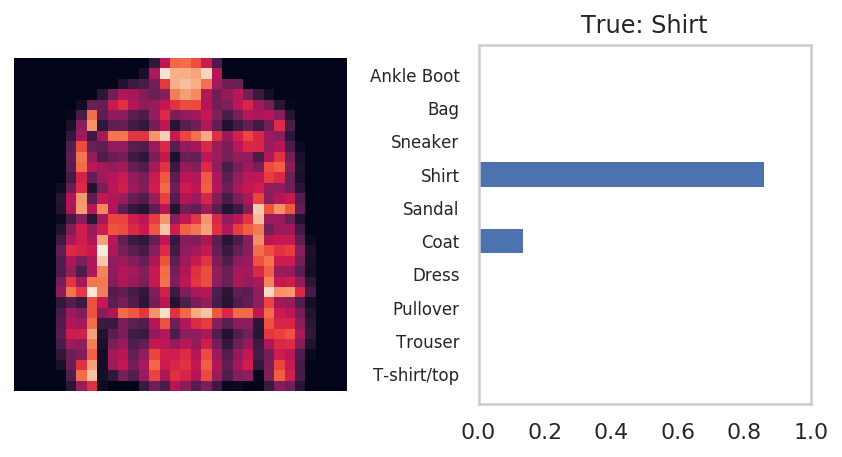

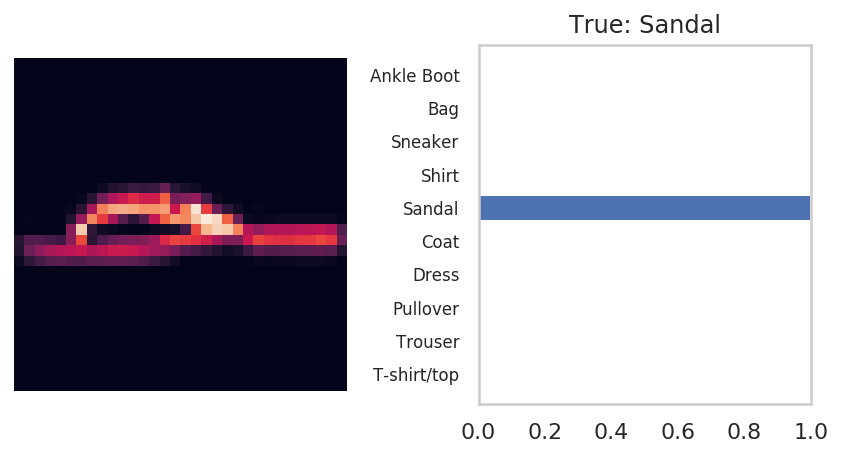

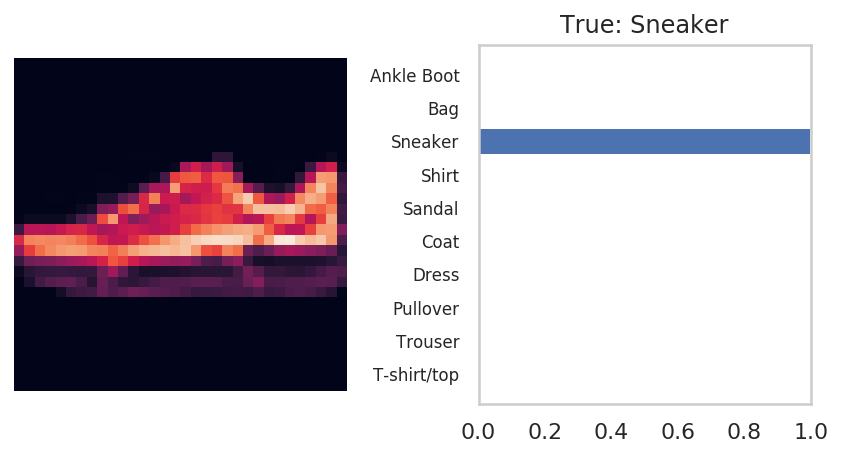

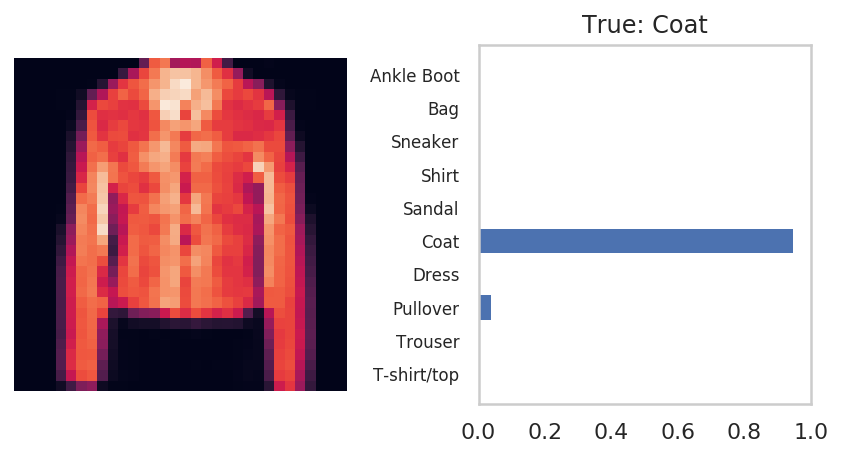

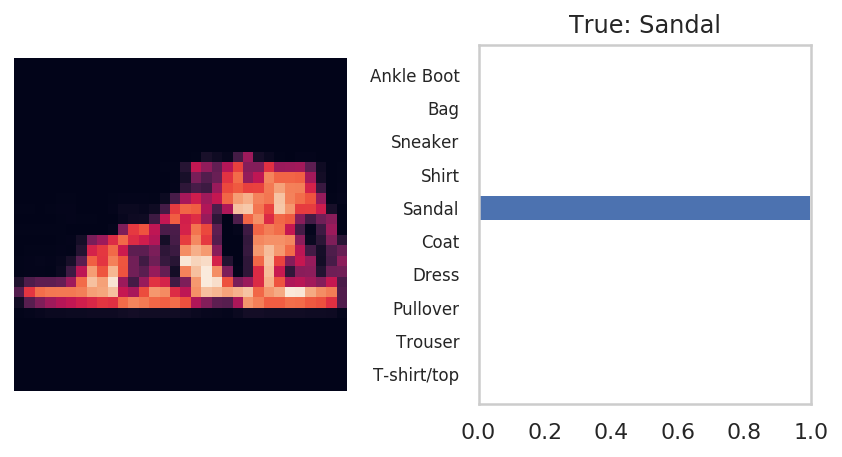

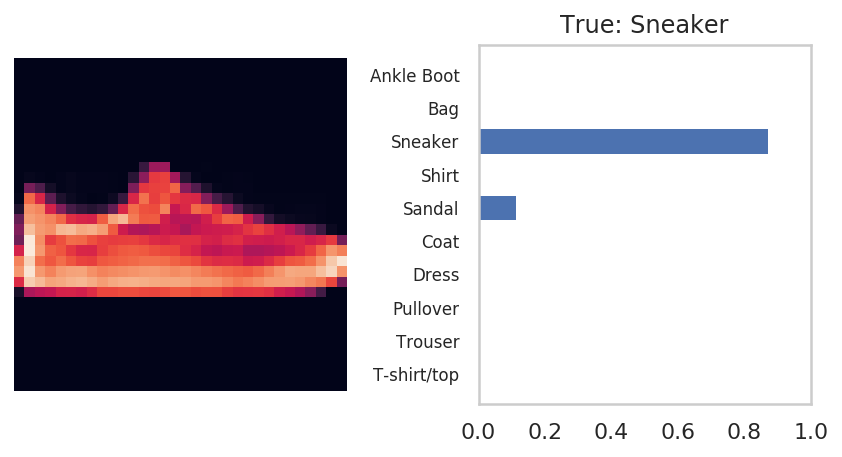

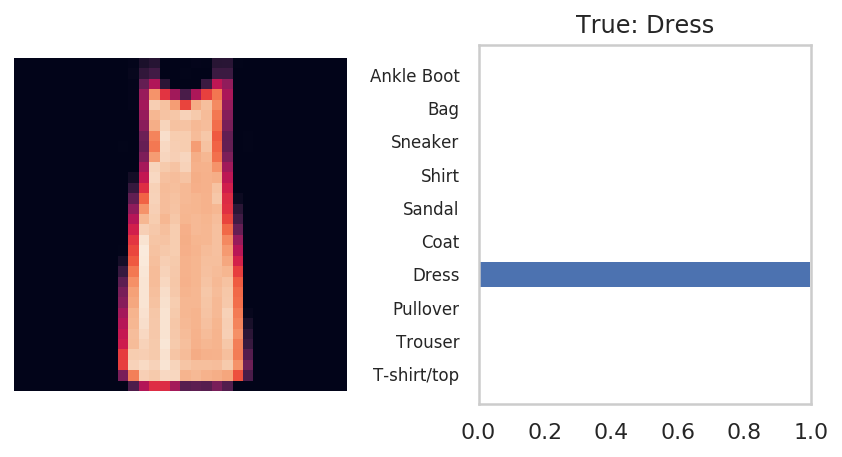

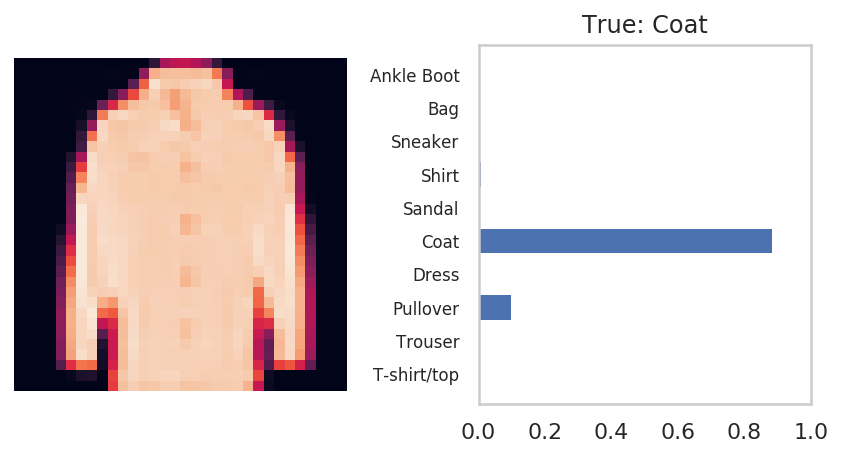

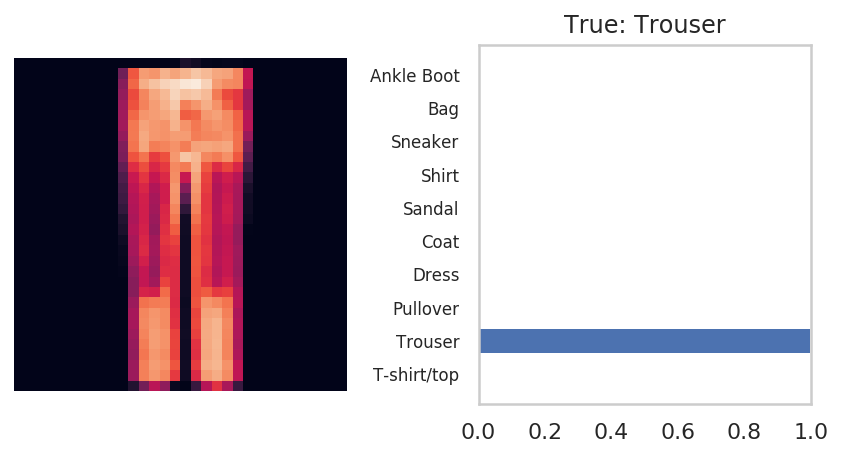

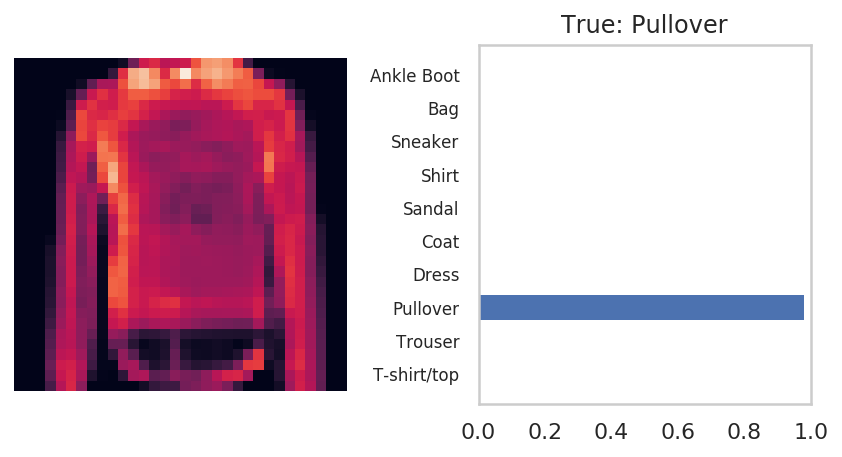

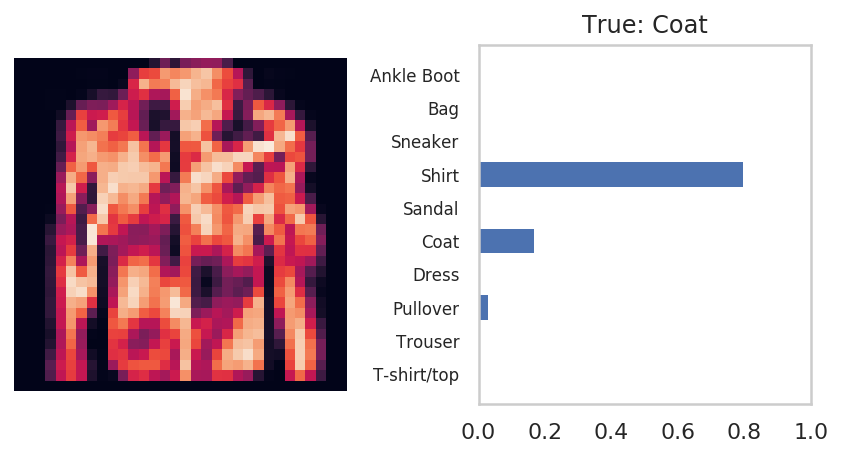

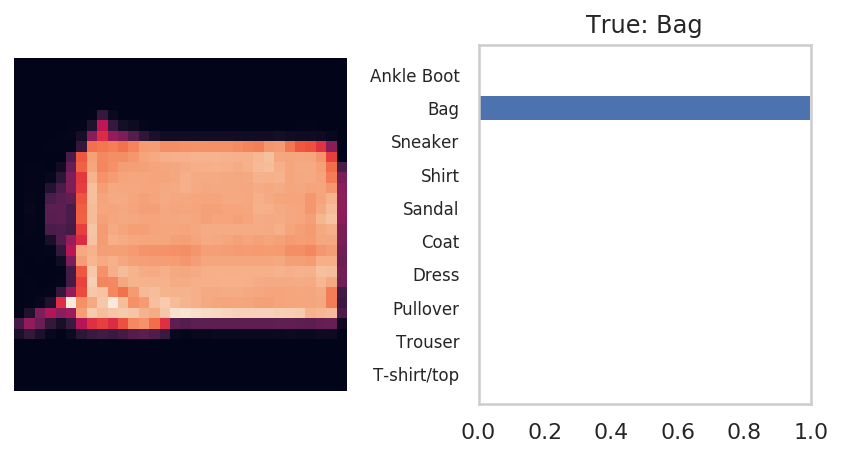

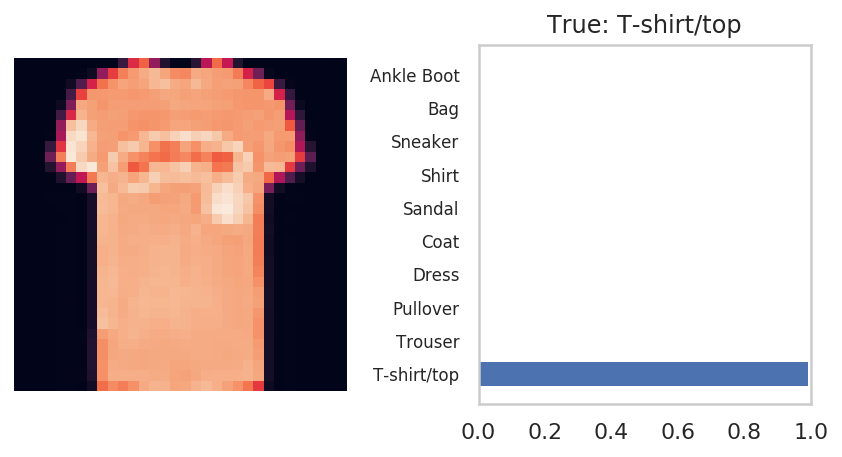

In [0]:
m = 20
display_test(m)  # No. of Images for predictions
print("Graphical prediction of 20 images from testing data set") #increase m if more test images needed.

In [0]:
correct = 0
total = 0
for images, labels in data_test_loader:
    images, labels = images.to(device), labels.to(device) ## Move to Cuda
    images = Variable(images.float())
    outputs = cnn(images)
    _, predicted = torch.max(outputs.data, 1)
    total += labels.size(0)
    # print(labels)
    correct += (predicted == labels).sum()
    
print('Accuracy of the model on the testing_set (consist of 1000+ images): %.4f %%' % (100 * correct / total))

Accuracy of the model on the testing_set (consist of 1000+ images): 89.0000 %
